Import Libraries

In [ ]:
import os
import shutil
from PIL import Image
import numpy as numpy
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Dropout, Conv2D, Activation, MaxPooling2D, UpSampling2D, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split


In [21]:
def read_file(file_path, delimiter=','):
    try:
        meta_data = pd.read_csv(file_path)
        return meta_data
    except FileNotFoundError:
        print(f"{file_path} does not exist")
        return None
meta_data = read_file('HAM10000_metadata.txt')
meta_data.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,dataset
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,vidir_modern
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,vidir_modern
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,vidir_modern
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,vidir_modern
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,vidir_modern


Understanding The Data

In [22]:
meta_data.info()
meta_data.drop(meta_data.columns[-1], axis=1, inplace=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10015 entries, 0 to 10014
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   lesion_id     10015 non-null  object 
 1   image_id      10015 non-null  object 
 2   dx            10015 non-null  object 
 3   dx_type       10015 non-null  object 
 4   age           9958 non-null   float64
 5   sex           10015 non-null  object 
 6   localization  10015 non-null  object 
 7   dataset       10015 non-null  object 
dtypes: float64(1), object(7)
memory usage: 626.1+ KB


In [23]:
meta_data.nunique()

lesion_id        7470
image_id        10015
dx                  7
dx_type             4
age                18
sex                 3
localization       15
dtype: int64

In [24]:
print(meta_data['localization'].unique())
print(meta_data['dx'].unique())

['scalp' 'ear' 'face' 'back' 'trunk' 'chest' 'upper extremity' 'abdomen'
 'unknown' 'lower extremity' 'genital' 'neck' 'hand' 'foot' 'acral']
['bkl' 'nv' 'df' 'mel' 'vasc' 'bcc' 'akiec']


In [25]:
meta_data.isna().sum()

lesion_id        0
image_id         0
dx               0
dx_type          0
age             57
sex              0
localization     0
dtype: int64

In [26]:
median_age = meta_data['age'].median()
meta_data['age'] = meta_data['age'].fillna(median_age)
meta_data['age'] = meta_data['age'].astype(int)
meta_data['age'].isna().sum()

0

Rename Columns and Labels

In [27]:
meta_data = meta_data.rename(columns={
    'dx': 'diagnosis',
    'dx_type': 'diagnosis_method',
    'localization': 'lesion_site'
})

In [28]:
diagnosis_rename = {
    'bkl': 'Benign keratosis-like lesions',
    'nv': 'Melanocytic nevi',
    'mel': 'Melanoma',
    'akiec': 'Actinic keratoses',
    'bcc': 'Basal cell carcinoma',
    'df': 'Dermatofibroma',
    'vasc': 'Vascular lesions'
}

meta_data['diagnosis'] = meta_data['diagnosis'].replace(diagnosis_rename)
meta_data['diagnosis'].unique()

array(['Benign keratosis-like lesions', 'Melanocytic nevi',
       'Dermatofibroma', 'Melanoma', 'Vascular lesions',
       'Basal cell carcinoma', 'Actinic keratoses'], dtype=object)

Adding Image Path Corresponding to Label

In [ ]:
import os
import pandas as pd

# Đường dẫn thư mục ảnh
image_dataset = r'E:\HAM'
diagnosis_dict = pd.Series(meta_data['diagnosis'].values, index=meta_data['image_id']).to_dict()

# Lấy danh sách ảnh từ thư mục
image_files = [f for f in os.listdir(image_dataset) if f.endswith(('jpg', 'jpeg', 'png'))]

# Tạo một dictionary lưu ảnh, nhãn và đường dẫn của chúng
image_info = {}

for image in image_files:
    # Lấy Image_ID từ tên file ảnh (giả sử tên ảnh là Image_ID.jpg)
    image_id = os.path.splitext(image)[0]  # Loại bỏ phần mở rộng của file (như .jpg, .png)
    
    # Tạo đường dẫn đầy đủ của ảnh
    image_path = os.path.join(image_dataset, image)
    
    # Lưu đường dẫn vào dictionary
    image_info[image_id] = image_path

# Thêm cột 'path' vào meta_data dựa trên image_id
meta_data['path'] = meta_data['image_id'].map(image_info)

# Gán lại nhãn cho ảnh
meta_data['Up_Diagnosis'] = meta_data['image_id'].map(diagnosis_dict)

# In ra DataFrame hoàn chỉnh
meta_data.head()


,lesion_id,image_id,diagnosis,diagnosis_method,age,sex,lesion_site,path,Up_Diagnosis
0,HAM_0000118,ISIC_0027419,Benign keratosis-like lesions,histo,80,male,scalp,NaN,Benign keratosis-like lesions
1,HAM_0000118,ISIC_0025030,Benign keratosis-like lesions,histo,80,male,scalp,NaN,Benign keratosis-like lesions
2,HAM_0002730,ISIC_0026769,Benign keratosis-like lesions,histo,80,male,scalp,NaN,Benign keratosis-like lesions
3,HAM_0002730,ISIC_0025661,Benign keratosis-like lesions,histo,80,male,scalp,E:\HAM_images_labels\ISIC_0025661.jpg,Benign keratosis-like lesions
4,HAM_0001466,ISIC_0031633,Benign keratosis-like lesions,histo,75,male,ear,NaN,Benign keratosis-like lesions


Filtering Nan Values

In [30]:
meta_data.dropna(inplace=True)

In [31]:
nan_in_path = meta_data['path'].isna().sum()
print(f'Number of NaN in path column: {nan_in_path}')

Number of NaN in path column: 0


Label Encoder

In [32]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()

# Số hóa cột 'label'
meta_data['label_encoded'] = label_encoder.fit_transform(meta_data['Up_Diagnosis'])

# Tạo dictionary ánh xạ từ nhãn chữ sang giá trị số
label_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))

# In ra kết quả
print(label_mapping) 

{'Actinic keratoses': 0, 'Basal cell carcinoma': 1, 'Benign keratosis-like lesions': 2, 'Dermatofibroma': 3, 'Melanocytic nevi': 4, 'Melanoma': 5, 'Vascular lesions': 6}


Visualization

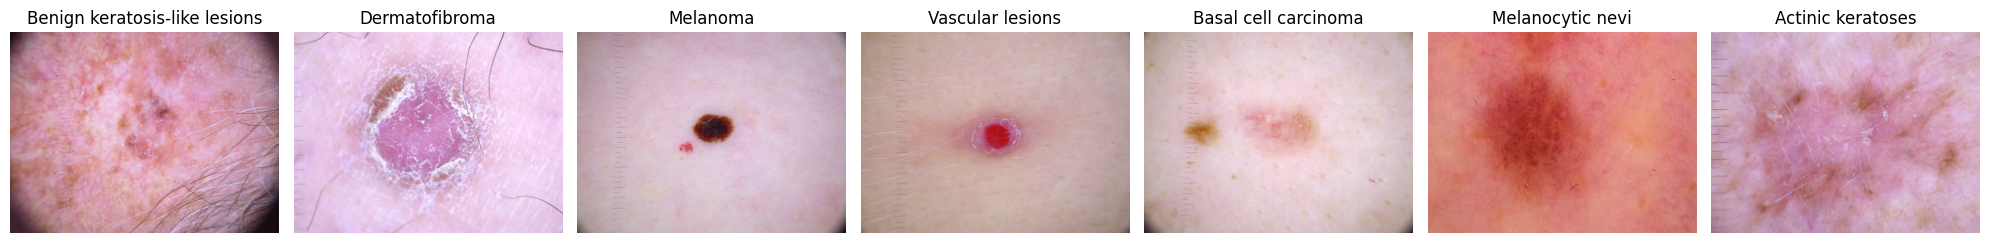

In [33]:
import matplotlib.image as mpimg
unique_labels = meta_data['Up_Diagnosis'].unique()
plt.figure(figsize=(20, 5))  # Điều chỉnh kích thước của figure để hiển thị tất cả ảnh trong một hàng

# Tạo set để theo dõi nhãn đã được hiển thị
displayed_labels = set()

# Lặp qua mỗi nhãn và hiển thị ảnh đại diện
for idx, label in enumerate(unique_labels):
    # Kiểm tra xem nhãn này đã hiển thị chưa
    if label not in displayed_labels:
        # Lọc ra các ảnh có nhãn hiện tại
        filtered_data = meta_data[meta_data['Up_Diagnosis'] == label]
        # Lấy đường dẫn của ảnh đầu tiên trong danh sách
        image_path = filtered_data['path'].iloc[0]
        # Đọc ảnh
        img = mpimg.imread(image_path)
        # Vẽ ảnh
        plt.subplot(1, len(unique_labels), idx + 1)  # Vẽ trên một hàng duy nhất
        plt.imshow(img)
        plt.title(f'{label}')  # Đặt tiêu đề là tên nhãn
        plt.axis('off')  # Tắt hiển thị trục toạ độ
        
        # Đánh dấu nhãn này là đã hiển thị
        displayed_labels.add(label)

# Hiển thị toàn bộ ảnh
plt.tight_layout()
plt.show()

In [34]:
# !pip install scikit-image
# !pip install imgaug

Augmentation

In [35]:
from skimage import io
from imgaug import augmenters as iaa
from skimage.io import imsave
import random

In [36]:
# Khởi tạo pipeline augmentations
aug_pipeline = iaa.Sequential([
    iaa.Fliplr(0.5),  # Horizontal flip with probability 0.5
    iaa.Affine(rotate=(-10, 10)),  # Random rotation within -10 to 10 degrees
    iaa.Affine(scale={"x": (0.9, 1.1), "y": (0.9, 1.1)}),  # Random scaling within 90% to 110%
    iaa.Crop(percent=(0, 0.2)),  # Crop images from each side by 0% to 20% of their height/width
    iaa.Affine(shear=(-5, 5)),  # Random shear within -5 to 5 degrees
    iaa.GaussianBlur(sigma=(0, 0.5)),  # Gaussian blur with a small sigma
    iaa.AdditiveGaussianNoise(scale=(0, 0.01*255)),  # Small additive Gaussian noise
    iaa.ContrastNormalization((0.9, 1.1)),  # Slightly change contrast
    iaa.CLAHE(clip_limit=(1, 2))  # Apply CLAHE with a moderate clip limit
])

# Đường dẫn lưu các ảnh augmented
augmented_images_dir = "E:/augmented_images2"
os.makedirs(augmented_images_dir, exist_ok=True)

# Lấy số lượng mẫu của từng nhãn
class_counts = meta_data['diagnosis'].value_counts()
max_count = class_counts.max()

balanced_samples = []

# Lặp qua từng nhãn trong meta_data để thực hiện augmenting
for label in class_counts.index:
    class_subset = meta_data[meta_data['diagnosis'] == label]

    # Nếu số lượng mẫu ít hơn lớp chiếm ưu thế, tiến hành augment
    if len(class_subset) < max_count:
        n_augmentations = max_count - len(class_subset)  # Số lượng ảnh cần tạo thêm
        augmented_samples = []

        # Tạo ảnh augmented cho từng mẫu trong lớp này
        for i in range(n_augmentations):
            sample = class_subset.sample(n=1, random_state=42).iloc[0]
            img_path = sample['path']
            img = io.imread(img_path)
            augmented_image = aug_pipeline(image=img)  # Áp dụng augmentations

            # Lưu ảnh augmented
            augmented_image_path = os.path.join(augmented_images_dir, f'{label}_augmented_{i}.jpg')
            imsave(augmented_image_path, augmented_image)

            # Cập nhật lại thông tin sample trong dataframe
            augmented_sample = sample.copy()
            augmented_sample['path'] = augmented_image_path
            augmented_samples.append(augmented_sample)

        # Gộp dữ liệu augmented vào class_subset
        augmented_df = pd.DataFrame(augmented_samples)
        class_oversampled = pd.concat([class_subset, augmented_df], ignore_index=True)
    else:
        # Nếu số lượng mẫu đủ lớn, không cần augment
        class_oversampled = class_subset

    balanced_samples.append(class_oversampled)

# Kết hợp các mẫu đã được cân bằng vào dataframe mới
balanced_dataset = pd.concat(balanced_samples).reset_index(drop=True)

# Gán lại balanced_dataset vào meta_data
meta_data = balanced_dataset

# In thông báo thành công
print("Dataset balanced successfully!")

c:\Users\Trung Nguyen\miniconda3\envs\tf\lib\site-packages\imgaug\imgaug.py:184: DeprecationWarning: Function `ContrastNormalization()` is deprecated. Use `imgaug.contrast.LinearContrast` instead.
  warn_deprecated(msg, stacklevel=3)


KeyboardInterrupt: 

Save Data

In [ ]:
# meta_data.to_csv('E:\meta_data_balanced.csv', index=False)
meta_data.to_pickle('E:\meta_data_balance2.pkl')


In [ ]:
# split_dir = r'E:\HAM10000_full'
# train_dir = os.path.join(split_dir, 'Train')
# test_dir = os.path.join(split_dir, 'Test')

# # Tạo thư mục chính cho train và test nếu chưa có
# os.makedirs(train_dir, exist_ok=True)
# os.makedirs(test_dir, exist_ok=True)

# # Chia ảnh và nhãn thành 80% train và 20% test
# image_names = list(image_labels.keys())
# labels = list(image_labels.values())

# # Sử dụng train_test_split để chia thành train và test
# train_images, test_images, train_labels, test_labels = train_test_split(image_names, labels, test_size=0.2, random_state=42)
# train_i, test_i, train_l, test_l = train_test_split(train_images, train_labels, test_size=0.2, random_state=42)

# # Hàm tạo thư mục cho từng nhãn và di chuyển ảnh vào thư mục
# def move_images_to_folders(image_list, labels, base_dir):
#     for image, label in zip(image_list, labels):
#         label_dir = os.path.join(base_dir, label)
#         os.makedirs(label_dir, exist_ok=True)  # Tạo thư mục nhãn nếu chưa có
        
#         # Lấy đường dẫn ảnh
#         image_path = os.path.join(image_dataset, image)
#         destination_path = os.path.join(label_dir, image)
        
#         # Di chuyển ảnh vào thư mục nhãn tương ứng
#         shutil.copy(image_path, destination_path)

# # Di chuyển ảnh vào thư mục train và test
# move_images_to_folders(train_i, train_l, train_dir)
# move_images_to_folders(test_i, test_l, test_dir)

# print(f"Images have been successfully split and moved to '{split_dir}'")